<a href="https://colab.research.google.com/github/blurrydev/Python-Notebooks-IITM/blob/main/%5BWeek_5%5D_%5BMLP%5D_Image_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Class image classification

### Importing Libraries

In [ ]:
# common imports
import numpy as np
import os
import io
import warnings

# sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, precision_score, recall_score, classification_report, make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# to plot pretty figures
import matplotlib.pyplot as plt
import seaborn as sns

Since this is a binary classification problem so we will try to figureout wheather a given image is 0 or not

#### Data Loading and splitting

In [ ]:
X,y = fetch_openml('mnist_784', version = 1, return_X_y = True)
#returns data & label as pandas dataframe

The data matrix X and the respective label vector y need to be converted to the numpy array by calling a to_numpy method

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

- Let's get some information like number of features, number of classes about the dataset
- Obesrve if the labels are of string datatype not integer

In [ ]:
target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0],X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum: {0}, Maximum: {1}'.format(np.min(X), np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names), y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:float64
Number of features: 784
Minimum: 0.0, Maximum: 255.0
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Scaling the features

In [ ]:
X = MinMaxScaler().fit_transform(X)
print('Minimum: {0}, Maximum: {1}'.format(np.min(X), np.max(X)))

Minimum: 0.0, Maximum: 1.0


Data Visualization

Let us pick a few images (images are already shuffled in the dataset) & display them with their respective labels. As said above, the images are stacked as row vector of size 1 x 784 & therefore must reshaped to the size 28 x 28 to display them properly.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


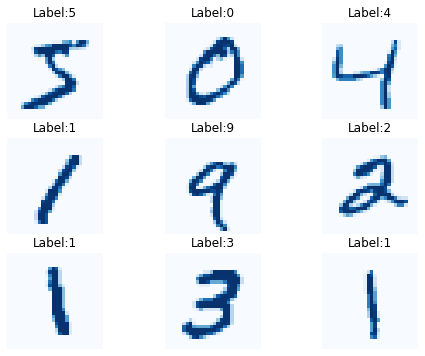

In [ ]:
num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows = factor, ncols= factor, figsize = (8,6))
idx_offset = 0 #take num images starting from the index 'idx_offset'
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap = 'Blues')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

#### Splitting the data

- We have gathered information about the number of samples, size of each sample, number of features (784), number if classes (targets) about the dataset.
- So let's split the total number of samples into train & test set in the following ratio: 60000/10000
- Since samples in the data are already shuffled so use of `train_test_split()` can be skipped.

In [ ]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before procedding further we need to check if this dataset is balanced or imbalanced. We can do it by plotting the distribution samples of each classes.

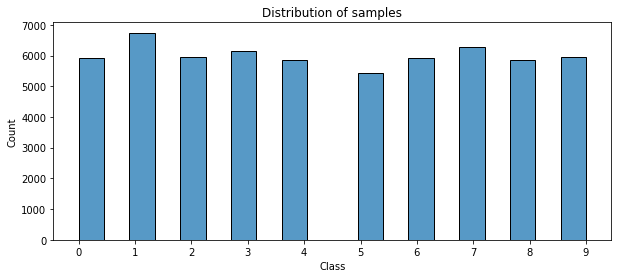

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data = np.int8(y_train), binwidth = 0.45, bins = 11)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9], labels = [0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## Binary Classification: 0 Detector

### Modifying Labels

- Since the original label vectcor contains 10 classes, we need to modify the number of classes to 2
- Therefore the label 0 will be changed to 1 and all other labels will be changed to -1
- We name the label vector as y_train_0 y_test_0

In [ ]:
# initialize new variables names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))


# find indices of digit 0 image
indx_0 = np.where(y_train == '0') # original labels are of type str not int
# use those indices to modify y_test_0 and y_train_0
y_train_0[indx_0] = 1

indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


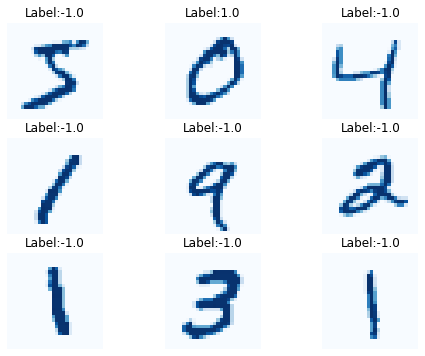

In [ ]:
num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows = factor, ncols= factor, figsize = (8,6))
idx_offset = 0 #take num images starting from the index 'idx_offset'
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap = 'Blues')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

## Baseline model

Enough about data!

lets create a baseline model with the following rule:
- Count number of samples per class.
- The model always outputs the class with the highest number of samples.
- Then calculate the accuracy of the baseline model.

In [ ]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])
print(num_pos, num_neg)

5923 54077


In [ ]:
base_clf = DummyClassifier(strategy = 'most_frequent') # there are other strategies

In [ ]:
base_clf.fit(x_train, y_train_0)
print('Training accuracy: {0:.2f}'.format(base_clf.score(x_train, y_train_0)))
print('Testing accuracy: {0: .2f}'.format(base_clf.score(x_test, y_test_0)))

Training accuracy: 0.90
Testing accuracy:  0.90


- The reason for such good accuracy is obvious. The model has 54077 labels with -1, so it is the most frequent value.
- So if the model outputs -1 for all the samples then the accuracy will be 54077/60000 = 90.12%
- This is why accuracy alone is not a good measure.

## Perceptron Model

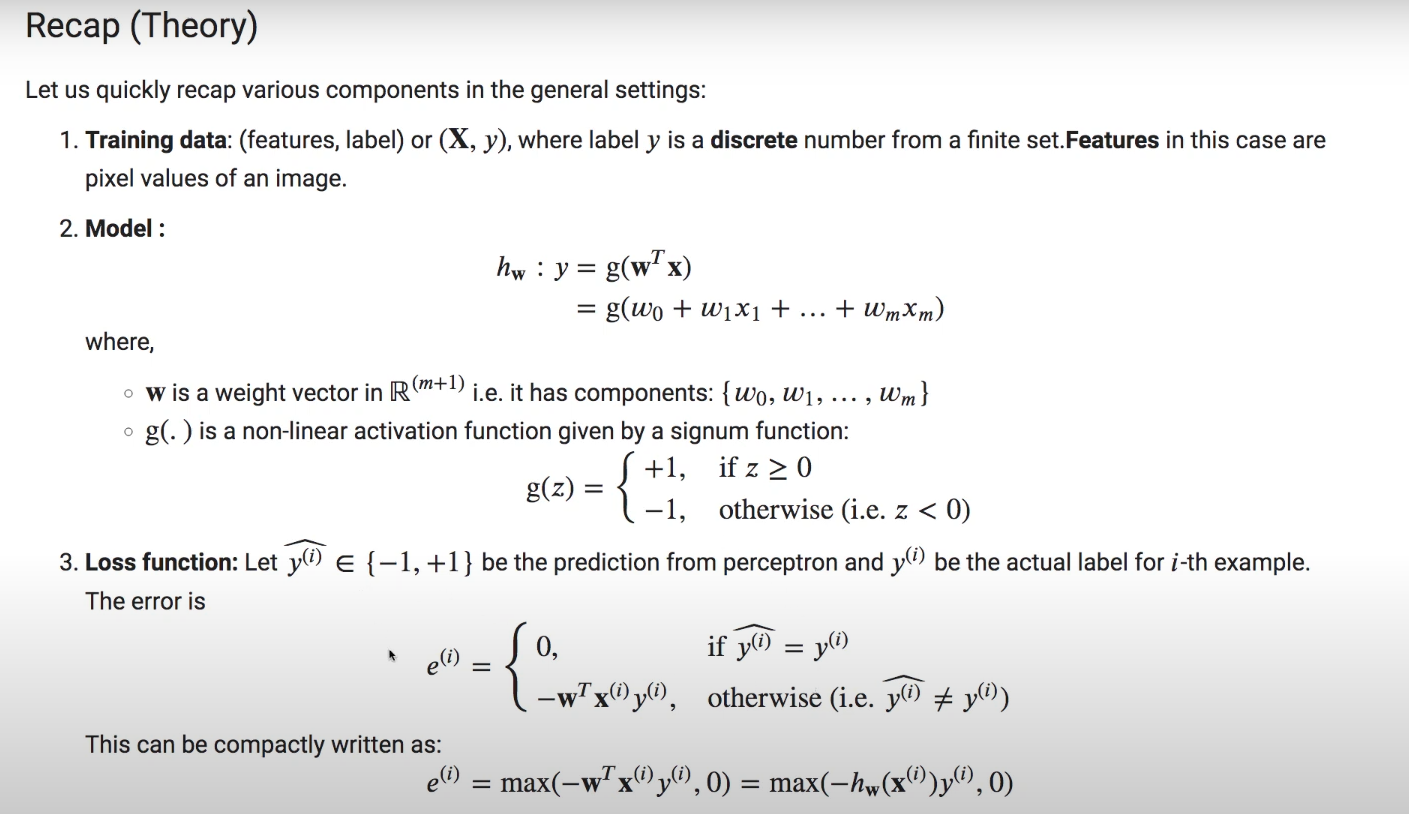

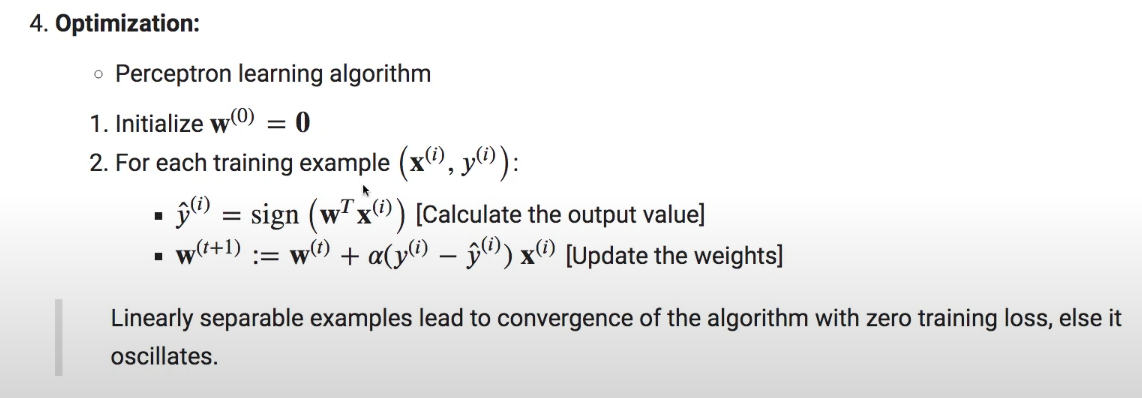

## Instantiation

- Create an instance of `bin_clf` and call the `fit` method totrain the model

In [ ]:
bin_clf = Perceptron(max_iter = 100, random_state = 1729)

## Training and prediction

- Call the `fit` method to train the model.
- It would be nice to plot the iteration vs loss curve for the training. However, sklearn does not have a direct function to plot it.
- Nevertheless, we can workaround with the `partial_fit` method.

In [ ]:
bin_clf.fit(x_train, y_train_0)
print('Dimentions of weights w: {0}'.format(bin_clf.coef_.shape))
print('Bias: {0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimentions of weights w: (1, 784)
Bias: [-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x7fc469ca38b0>


In [ ]:
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy: {0}'.format(bin_clf.score(x_train, y_train_0)))

Training Accuracy: 0.99095


Let us make predictions on the training accuracy

In [ ]:
y_hat_test_0 = bin_clf.predict(x_test)
print('Test accuracy: ', bin_clf.score(x_test, y_test_0))

Test accuracy:  0.989


### Displaying predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


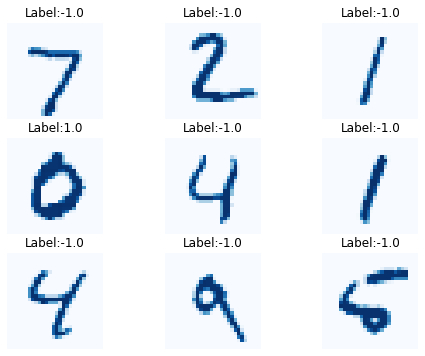

In [ ]:
num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows = factor, ncols= factor, figsize = (8,6))
idx_offset = 0 #take num images starting from the index 'idx_offset'
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28), cmap = 'Blues')
    ax[i,j].set_title('Label:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

In [ ]:
indx_0 = np.where(y_test_0 == 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


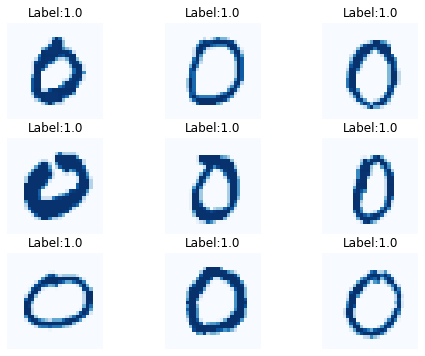

In [ ]:
zeroImgs = x_test[indx_0[0]]
zeroLabels = y_hat_test_0[indx_0[0]]


num_images = 9 #choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows = factor, ncols= factor, figsize = (8,6))
idx_offset = 0 #take num images starting from the index 'idx_offset'
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28), cmap = 'Blues')
    ax[i,j].set_title('Label:{0}'.format(str(zeroLabels[index+j])))
    ax[i,j].set_axis_off()

Let's see how many classifications are correct

In [ ]:
num_missclassified = np.count_nonzero(zeroLabels == -1)
num_correctpred = len(zeroLabels) - num_missclassified
accuracy = num_correctpred / len(zeroLabels)
print(accuracy)

0.9193877551020408


- Note that this score will not be the same if we take any other number instead of 1 for positive class and negative for others.

## Better evaluation metrics

### Confusion matrix



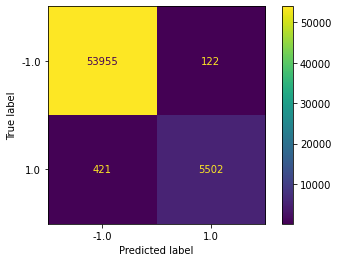

In [ ]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format = '.5g')
plt.show()

### Precision & recall

We can use `classification_report` to compute thisw parameters.

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [ ]:
precision = tp/(tp+fp)
print('Precision: ', precision)

recall = tp/(tp+fn)
print('Recall: ', recall)

accuracy = (tn+tp)/(tp+fp+tn+fn)
print('Accuracy: ', accuracy)

Precision:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy:  0.99095


### Cross Validation

In [ ]:
bin_clf = Perceptron(max_iter = 100, random_state = 1729) # repeating for readability
scores = cross_validate(bin_clf, x_train, y_train_0, cv = 5,
                        scoring = ['precision', 'recall', 'f1'],
                        return_estimator = True)

pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.39723063, 2.73403525, 1.95258331, 1.74474669, 2.21877694]),
 'score_time': array([0.05065846, 0.06104445, 0.04942298, 0.05145049, 0.05121207]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


- **Note:**
  
  The perceptron estimator passed as an argument to the function `cross_validate` is internally cloned `num_fold (cv=5)` times and fitted independently on each fold. (You can check this by `warm_start = True`)

  Compute the average and standard deviation of scores for all three matrics on (k=5) folds to measure the generalization.

In [ ]:
print('f1,          avg:{0:.2f},  std:{1:.3f}'.format(scores['test_f1'].mean(),scores['test_f1'].std()))
print('precision,   avg:{0:.2f},  std:{1:.3f}'.format(scores['test_precision'].mean(),scores['test_precision'].std()))
print('recall,      avg:{0:.2f},  std:{1:.3f}'.format(scores['test_recall'].mean(),scores['test_recall'].std()))

f1,          avg:0.94,  std:0.013
precision,   avg:0.96,  std:0.013
recall,      avg:0.92,  std:0.035


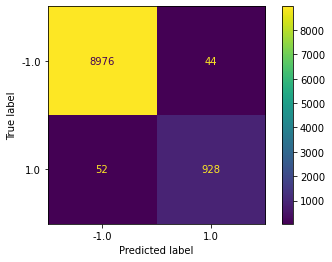

In [ ]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format = '.5g')

In [ ]:
print('Precision %.2f' %precision_score(y_test_0, y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0, y_hat_test_0))

Precision 0.95
Recall 0.95


**Way-2 for generalization:**

- There is an another approach of getting predicted labels via cross-validation & using it to measure generalization.
- In this case, each sample in the dataset will be a part of only one test set in the splited folds.

In [ ]:
y_hat_train_0 = cross_val_predict(bin_clf, x_train, y_train_0, cv = 5)

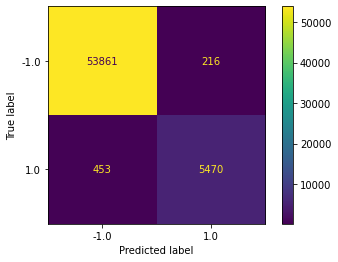

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format = '.5g')
plt.show()

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [ ]:
precision = tp/(tp+fp)
print('Precision: ', precision)

recall = tp/(tp+fn)
print('Recall: ', recall)

accuracy = (tn+tp)/(tp+fp+tn+fn)
print('Accuracy: ', accuracy)

Precision:  0.9620119591980303
Recall:  0.9235184872530812
Accuracy:  0.98885


In [ ]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## Precision/Recall Tradeoff

- It is important to know that we should not pass the predicted labels as input to `precision_reall_curve` function, instead we need to pass the probability score or the output of the decision function!

- The `Perceptron()` class contains the `decision_function` method, therefore we can make use of it.
- Then, internally the decision scores are sorted, **tps** & **fps** will be computed by changing the threshold from index[0] to index[-1].
-Let's compute the decision funtion.

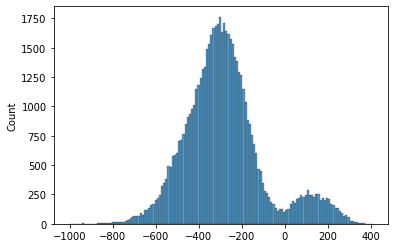

In [ ]:
bin_clf = Perceptron(random_state = 1729)
bin_clf.fit(x_train, y_train_0)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

Can you think why there are so many negative values than positives?

**Hint:** Class-Imbalance

- Suppose threshold takes value -600 then all the samples having score greater than -600 is set to 1 (positive label) and less than it is set to -1 (ng label).
- Therefore, the number of Flase Positives will increase, this will inturn reduce the precision score to a greater extent.
- On the other hand if thereshold takes a value of 400 the false negative rate will increase.
- Let's see in action.

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label = 1)

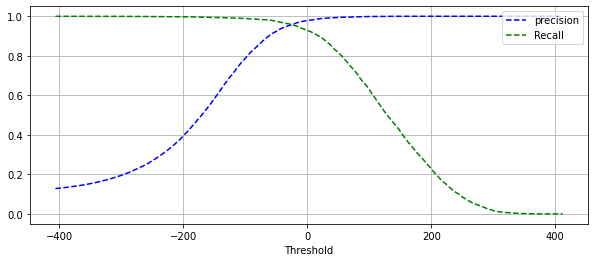

In [ ]:
plt.figure(figsize = (10,4))
plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'Recall')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
# get index of threshold around Zero
idx_th = np.where(np.logical_and(thresholds > 0, thresholds < 1))
print('precision for zero threshold:', precisions[idx_th[0][0]])

precision for zero threshold: 0.9783072546230441


## The ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

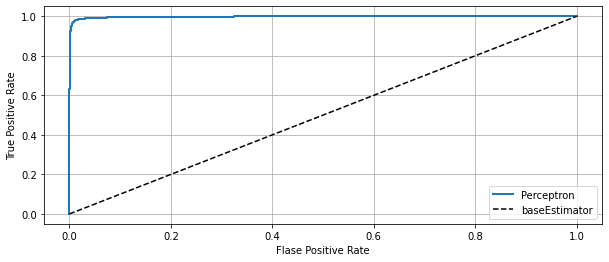

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize= (10,4))
plt.plot(fpr, tpr, linewidth = 2, label = 'Perceptron')
plt.plot([0,1],[0,1], 'k--', label = 'baseEstimator')
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

# Multiclass Classifier

- We know that perceptron is a binary classifier. However MINST classifier contains 10 classes, then how can we extend this idea to handle multi-class problems?
- **Solution:** Combine multiple binary classifiers & device a suitable scoring metric.
- sklearn makes it easy without modifying a single line of code that we have written for the binary classifier.
- sklearn does this by counting a number of unique elements (10 in this case) the label vector `y_train` & converting labels using `LabelBinarizer` to fit each binary classifier.

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer

In [ ]:
clf = Perceptron(random_state = 1729)

In [ ]:
# let's use label binarizer just to see the encoding
y_train_ovr = LabelBinarizer().fit_transform(y_train) # setting sparse_output True in LabelBinarizer() improves efficiency
for i in range(10):
  print('{0}:{1}'.format(y_train[i], y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


In [ ]:
clf.fit(x_train, y_train)

Perceptron(random_state=1729)

- What actually happened internally was that the API automatically created 10 binary classifiers, converted labels to binary sparse matrix and trained them with the binarized label.
- During the inference time the output will be passed through all 10 classifiers and the highest score among the output of the classifiers will be considered as the predicted class.
- To see it in action let's execute the following line of code.

In [ ]:
print('Shape of Weight matrix: {0} & bias vector: {1}'.format(clf.coef_.shape, clf.intercept_.shape))

Shape of Weight matrix: (10, 784) & bias vector: (10,)


- So it is a matrix of size 10 x 784 where each row represents the weights for a single binary classifier.
- Important difference to note is that there is no signum function associated with the perceptron.
- The class of a perceptron that outputs the maximum score for the input sample is considered as the predicted class.

In [ ]:
scores = clf.decision_function(x_train[6].reshape(1,-1))
print(scores)
print('The predicted class: ', np.argmax(scores))

[[-631.88492118  154.366213    -65.23234141  -90.95338716 -189.29568627
  -137.14385236  -99.64604383 -159.09859285 -136.86391388 -199.26120723]]
The predicted class:  1


In [ ]:
print('Predicted output:\n')
print(clf.predict(x_train[0].reshape(1,-1)))

Predicted output:

['5']


In [ ]:
# get the  prediction for all training samples
y_hat = clf.predict(x_train)

In [ ]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



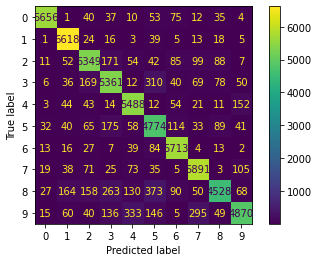

In [ ]:
# displaying the confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat, values_format = '.5g') #it returns matplotlib plot object

## Making a pipeline

- Let's create a pipeline to keep the code compact
- Recall that MNIST dataset is clean and it doesn't require much preprocessing.
- The one potential preprocessing that we may use is to scale the features within  the range (0,1)
- It is **not** similar to scaling down the range values between 0 and 1.

In [ ]:
# create a list with named Tuples
estimators = [('std_sccaler', MinMaxScaler()),
              ('bin_clf', Perceptron())]
pipe = Pipeline(estimators)              

In [ ]:
pipe.fit(x_train, y_train_0)

Pipeline(steps=[('std_sccaler', MinMaxScaler()), ('bin_clf', Perceptron())])

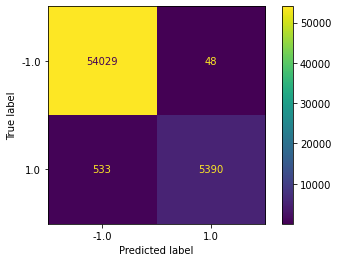

In [ ]:
y_hat_train_0 = pipe.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format = '.5g') # it return matplotlib plot object
plt.show()

## Iteration vs Loss Curve

In [ ]:
iterations = 100
bin_clf1 = Perceptron(max_iter =1000, random_state = 2094)
Loss_clf1 = []
for i in range(iterations):
  bin_clf1.partial_fit(x_train, y_train_0, classes = np.array([1,-1]))
  y_hat_0 = bin_clf1.decision_function(x_train)
  Loss_clf1.append(hinge_loss(y_train_0, y_hat_0))

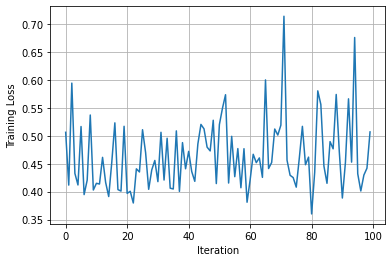

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

## GridsearchCV

- So far we didn't do any HPT for perceptron.
- Now, let us search for a better learning rate using `GridSearchCV`.
- No matter what the learning rate is the loss will never converge to Zero as the classes are not linearly separable.


In [ ]:
scoring = make_scorer(hinge_loss, greater_is_better= False)
lr_grid = [1/2**n for n in range(1,6)]
bin_clf_gscv = GridSearchCV(Perceptron(), param_grid = {'eta0': lr_grid}, scoring = scoring, cv =5)
bin_clf_gscv.fit(x_train, y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [ ]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.60184536, 1.97769732, 1.70533667, 1.29877896, 1.20264692]),
 'mean_score_time': array([0.02673655, 0.03019261, 0.02865982, 0.02531905, 0.0259151 ]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5], dtype=int32),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.

In [ ]:
iterations = 100
best_bin_clf = Perceptron(max_iter =1000, random_state = 2094, eta0 = 0.125)
Loss= []
for i in range(iterations):
  best_bin_clf.partial_fit(x_train, y_train_0, classes = np.array([1,-1]))
  y_hat_0 = best_bin_clf.decision_function(x_train)
  Loss.append(hinge_loss(y_train_0, y_hat_0))

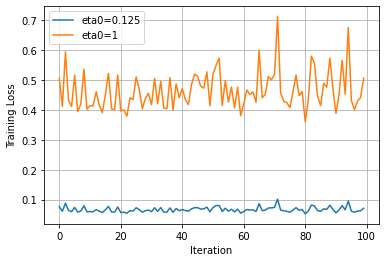

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss, label = 'eta0=0.125')
plt.plot(np.arange(iterations), Loss_clf1, label = 'eta0=1' )
plt.grid(True)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

## Visualizing Weight Vectors (Optinal)

It will be interesting to look into samples that are misclassified as False Positives & comeup with the possibles reasons.

In [ ]:
# repeating the code for readablity
bin_clf = Perceptron(max_iter = 100, random_state = 1729)
bin_clf.fit(x_train, y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)

In [ ]:
# find the index of flase positives samples
idx_n = np.where(y_train_0 == -1) #index of true -ve samples
idx_pred_p = np.where(y_hat_train_0 == 1) # index of predicted positive samples
idx_pred_n = np.where(y_hat_train_0 == -1) #index of predicted negative samples
idx_fp = np.intersect1d(idx_n, idx_pred_p)
idx_tn = np.intersect1d(idx_n,idx_pred_n)

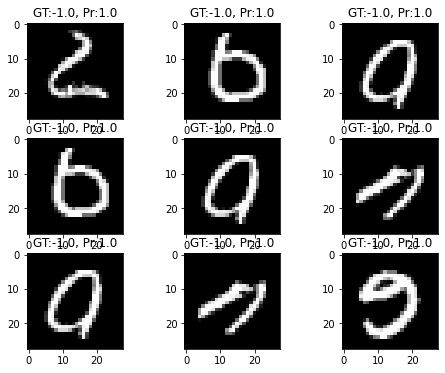

In [ ]:
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize = (8,6))
idx_offset = 0
for i in range(3):
  index = idx_offset + i
  for j in range(3):
    ax[i,j].imshow(x_train[idx_fp[index+j]].reshape(28,28), cmap = 'gray') # we should not use x_train_with_dummy
    ax[i,j].set_title('GT:{0}, Pr:{1}'.format(str(y_train_0[idx_fp[index+j]]), str(y_hat_train_0[idx_fp[index+j]])))
    ax[i,j].set_axis_off